# Network tests notebook
This notebook is used to compare the inferred networks to the ground truth networks through various tests

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime
%load_ext rpy2.ipython
import networkx as nx
import src.__init__ as init
timestep = init.TIME_STEP
timesteps = int(1440/timestep)

# Set fonts for plotting

# font_path = 'MyriadPro-Regular.otf'
# prop = fm.FontProperties(fname=font_path)
# matplotlib.rcParams['font.family'] = prop.get_name()

font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)

/usr/local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
%%R
glasso_adj = array(as.matrix(read.csv('data/graphs/glasso-adj.csv')), c(18,18))
influence_adj = array(as.matrix(read.csv('data/graphs/influence-adj.csv')), c(18,18))
interaction_adj = array(as.matrix(read.csv('data/graphs/interaction-adj.csv')), c(18,18))
info_adj = array(as.matrix(read.csv('data/graphs/info-adj.csv')), c(18,18))
prob_adj = array(as.matrix(read.csv('data/graphs/prob-adj.csv')), c(18,18))
support_adj = array(as.matrix(read.csv('data/graphs/support-adj.csv')), c(18,18))
socialnorm_adj = array(as.matrix(read.csv('data/graphs/socialnorm-adj.csv')), c(18,18))
org_adj = array(as.matrix(read.csv('data/graphs/org-adj.csv')), c(18,18))
ground_adj = array(as.matrix(read.csv('data/graphs/ground-adj.csv')), c(18,18))
graphs = list(glasso_adj, influence_adj, interaction_adj, info_adj, prob_adj, support_adj, socialnorm_adj, org_adj, ground_adj)
graphs[is.na(graphs)] <- 0

## Graph correlation

[1] 0.4531696

QAP Test Results

Estimated p-values:
	p(f(perm) >= f(d)): 0.002 
	p(f(perm) <= f(d)): 0.998 

Test Diagnostics:
	Test Value (f(d)): 0.4531696 
	Replications: 10000 
	Distribution Summary:
		Min:	 -0.5159509 
		1stQ:	 -0.1195987 
		Med:	 -0.005944072 
		Mean:	 -0.003388017 
		3rdQ:	 0.1078308 
		Max:	 0.55125 



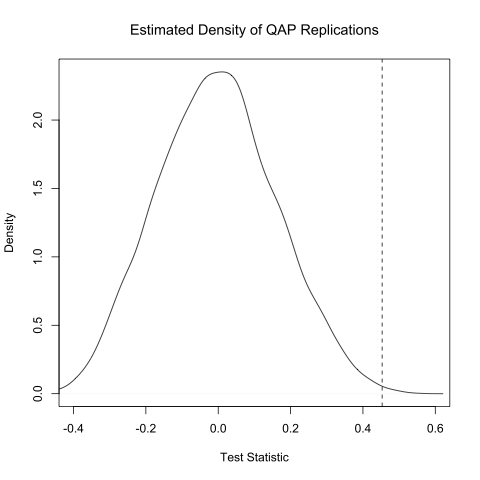

In [4]:
%%R
library(sna)
library(showtext)

# Use Myriad Pro
# library(showtext)
# font_add("MyriadPro",
#     regular = "MyriadPro-Regular.otf",
#     bold = "MyriadPro-Bold.otf")
# showtext_auto()

# Use Arial
library(showtext)
font_add("Arial", "Arial.ttf")
showtext_auto()

# Create a fully connected graph as a null model for baseline and test
full_adj <- matrix(rep(1, 18*18), 18,18)
length <- dim(full_adj)[1] * dim(full_adj)[2]
noise <- matrix(runif(length, -0.01, 0.01), dim(full_adj)[1])
full_adj <- full_adj + noise
diag(full_adj) <- 0

graph.Cor <- qaptest(list(ground_adj, interaction_adj), gcor, g1=1, g2=2, reps=10000)
print(gcor(ground_adj, interaction_adj), diag=FALSE, mode='graph')
print(summary(graph.Cor))

#png(width=1600, height=1600, res=300, file='cor-interaction.png')
plot(graph.Cor, xlim=c(-0.4, 0.6), family='Arial')

# Calculate graph correlations for all models
gcors <- gcor(graphs)
rownames(gcors) <- c('graphical\n lasso','influence\n model','interaction\n model', 'communi-\n cation','advice','trust','social','organi-\n zational','overall\n ground')
colnames(gcors) <- c('graphical\n lasso','influence\n model','interaction\n model', 'communi-\n cation','advice','trust','social','organi-\n zational','overall\n ground')

/usr/local/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: corrplot 0.84 loaded

  warnings.warn(x, RRuntimeWarning)


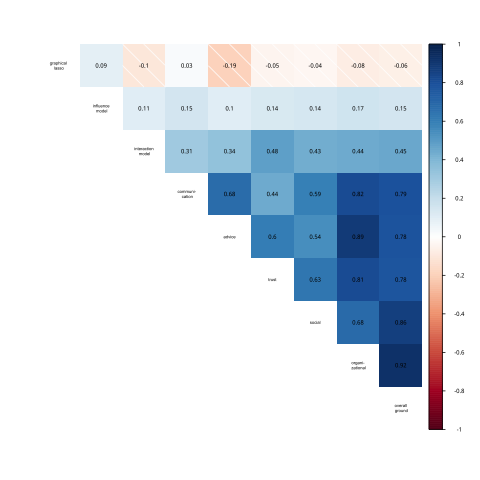

In [68]:
%%R
gcors_upper = gcors
UT = upper.tri(gcors_upper)
gcors_upper[UT] = gcors[UT]
diag(gcors_upper) = NA

library(corrplot)
#pdf(width=3.5, height=3.5, file='cor-talk.pdf')
#corrplot.mixed(gcors, lower='number', lower.col='black', upper='shade', tl.col='black', tl.cex=.35, cl.cex=0.6, number.cex=0.6, family='MyriadPro')
corrplot(gcors_upper, type='upper', method='shade', tl.col='black', tl.pos='d', tl.srt=90, family='Arial', addCoef.col = 'black', tl.cex=.35, cl.cex=0.5, number.cex=0.5, family='Arial')

## OLS Network Model test

In [108]:
%%R
# Choose any two adjacency matrices to compare
nl<-netlm((ground_adj), # Dependent variable/network
          list(influence_adj), # List the independent variables/networks
          reps=1000, # select the number of permutations
          mode='digraph',
          nullhyp='qap',
          intercept=TRUE)

#Examine the results
print(nl)


OLS Network Model

Coefficients:
            Estimate  Pr(<=b) Pr(>=b) Pr(>=|b|)
(intercept) 0.8415642 0.999   0.001   0.001    
x1          4.8199532 0.735   0.265   0.498    

Residual standard error: 0.6064 on 304 degrees of freedom
F-statistic: 2.115 on 1 and 304 degrees of freedom, p-value: 0.1469 
Multiple R-squared: 0.006908 	Adjusted R-squared: 0.003641 



## Mantel test

$z.stat
[1] 15.86033

$p
[1] 0.00609939

$alternative
[1] "two.sided"

[1] 0.5066379


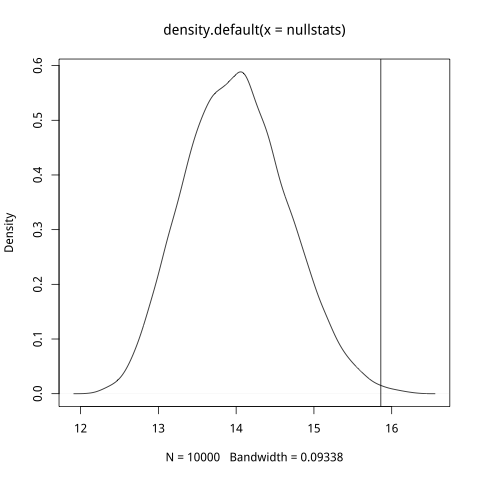

In [25]:
%%R
library(ade4)
library(ape)
## Choose any two adjacency matrices to compare
print(mantel.test(interaction_adj, org_adj, nperm=10000, graph=TRUE, alternative='two.sided'))
print(cor(as.vector(interaction_adj), as.vector(ground_adj), method='pearson'))

## How does gcor vary over time?

In [110]:
from importlib import reload
import src.interaction_model as im
im = reload(im)
classified = pd.read_csv('data/classified-berkeley.csv', index_col=0)
# Data segment 1: 08-09 to 10-09 (61 days) -- all occupants
overlaps1, similarities1 = im.interaction_matrix(classified['2018-08-09':'2018-10-09'])
# Data segment 2: 10-09 to 04-24 (197 days) -- occupant 10 gone
overlaps2, similarities2 = im.interaction_matrix(classified['2018-10-09':'2019-04-24'])
# Data segment 3: 04-24 to 06-17 (54 days) -- occupant 5 gone, occupant 10 gone
overlaps3, similarities3 = im.interaction_matrix(classified['2019-04-24':'2019-06-17'])
# Data segment 4: 06-17 to 08-09 (53 days) -- occupants 5 gone, occupant 10 in space 13, occupant 13 gone 
overlaps4, similarities4 = im.interaction_matrix(classified['2019-06-17':'2019-08-09'])

In [111]:
# Adjust similarity calculations for different data segments
similarities1_2 = (similarities1 + similarities2)/(61+197)
similarities1_2[9,:] = similarities1[9,:]/61
similarities1_2[:,9] = similarities1[:,9]/61
similarities1_3 = (similarities1_2*(61+197) + similarities3)/(61+197+54)
similarities1_3[4,:] = similarities1_2[4,:]
similarities1_3[:,4] = similarities1_2[:,4]
similarities1_3[9,:] = similarities1_2[9,:]
similarities1_3[:,9] = similarities1_2[:,9]
similarities = (similarities1_3*(61+197+54) + similarities4)/365
similarities[4,:] = similarities1_2[4,:]
similarities[:,4] = similarities1_2[:,4]
similarities[:,9] = (similarities1_3[:,9]*(61+197+54) + similarities4[:,12])/365
similarities[9,:] = (similarities1_3[9,:]*(61+197+54) + similarities4[12,:])/365
similarities[:,12] = similarities1_3[:,12]
similarities[12,:] = similarities1_3[12,:]
similarities = similarities[:18,:18]

In [186]:
###### import src.interaction_model as im
import dateutil
classified = pd.read_csv('data/classified-berkeley.csv', index_col=0)
classified = classified.iloc[:timesteps*364,:]
aggsims = []
batches = 52
for i in range(1,batches+1):
    data = classified.iloc[0:len(classified)-(batches-i)*(len(classified)//batches),:] # forward selection of data
    last = dateutil.parser.parse(data.index[-1])
    if last <= dateutil.parser.parse('2018-10-09 23:45:00'):
        aggsims.append(im.interaction_matrix(data)[1][0:18,0:18]/(i*365/52))
    elif last <= dateutil.parser.parse('2019-04-24 23:45:00'):
        s1 = im.interaction_matrix(data['2018-08-09':'2018-10-09'])[1][0:18,0:18]
        s2 = im.interaction_matrix(data['2018-10-09':])[1][0:18,0:18]
        s1_2 = (s1 + s2)/(i/batches*365)
        s1_2[9,:] = s1[9,:]/61
        s1_2[:,9] = s1[:,9]/61
        aggsims.append(s1_2)
    elif last <= dateutil.parser.parse('2019-06-17 23:45:00'):
        s1 = im.interaction_matrix(data['2018-08-09':'2018-10-09'])[1][0:18,0:18]
        s2 = im.interaction_matrix(data['2018-10-09':'2019-04-24'])[1][0:18,0:18]
        s3 = im.interaction_matrix(data['2019-04-24':])[1][0:18,0:18]
        s1_2 = (s1 + s2)/(61+197)
        s1_2[9,:] = s1[9,:]/61
        s1_2[:,9] = s1[:,9]/61
        s1_3 = (s1_2*(61+197) + s3)/(i/batches*365)
        s1_3[4,:] = s1_2[4,:]
        s1_3[:,4] = s1_2[:,4]
        s1_3[9,:] = s1_2[9,:]
        s1_3[:,9] = s1_2[:,9]
        aggsims.append(s1_3)
    else:
        s1 = im.interaction_matrix(data['2018-08-09':'2018-10-09'])[1][0:18,0:18]
        s2 = im.interaction_matrix(data['2018-10-09':'2019-04-24'])[1][0:18,0:18]
        s3 = im.interaction_matrix(data['2019-04-24':'2019-06-17'])[1][0:18,0:18]
        s4 = im.interaction_matrix(data['2019-06-17':])[1][0:18,0:18]
        s1_2 = (s1 + s2)/(61+197)
        s1_2[9,:] = s1[9,:]/61
        s1_2[:,9] = s1[:,9]/61
        s1_3 = (s1_2*(61+197) + s3)/(61+197+54)
        s1_3[4,:] = s1_2[4,:]
        s1_3[:,4] = s1_2[:,4]
        s1_3[9,:] = s1_2[9,:]
        s1_3[:,9] = s1_2[:,9]
        s = (s1_3*(61+197+54) + s4)/(i/batches*365)
        s[4,:] = s1_2[4,:]
        s[:,4] = s1_2[:,4]
        s[:,9] = (s1_3[:,9]*(61) + s4[:,12])/(i/batches*(61+53))
        s[9,:] = (s1_3[9,:]*(61) + s4[12,:])/(i/batches*(61+53))
        s[9,9] = 0
        s[:,12] = s1_3[:,12]
        s[12,:] = s1_3[12,:]
        aggsims.append(s)
        
# build model on 10 weeks of data for different parts of the year
aggsims_select = []

start = 10
for i in range(1,11):
    data = classified.iloc[timesteps*start*7:timesteps*start*7+timesteps*i*7,:]
    s2 = im.interaction_matrix(data)[1][0:18,0:18]
    s2[9,:] = 0
    s2[:,9] = 0
    aggsims_select.append(s2)

start = 24
for i in range(1,11):
    data = classified.iloc[timesteps*start*7:timesteps*start*7+timesteps*i*7,:]
    s2 = im.interaction_matrix(data)[1][0:18,0:18]
    s2[9,:] = 0
    s2[:,9] = 0
    aggsims_select.append(s2)

start = 37
for i in range(1,11):
    data = classified.iloc[timesteps*start*7:timesteps*start*7+timesteps*i*7,:]
    s3 = im.interaction_matrix(data)[1][0:18,0:18]
    s3[9,:] = 0
    s3[:,9] = 0
    s3[4,:] = 0
    s3[:,4] = 0
    aggsims_select.append(s3)

    #aggsims.append(im.interaction_matrix(classified.iloc[0:len(classified)-(50-i)*(len(classified)//50),:]))

In [187]:
# agginteraction_adjs = []
# for aggoverlap in aggoverlaps:
#     #totalaggoverlap = np.sum(aggoverlap[0][:,:,np.r_[0:96]], axis=2)
#     #agginteraction_adj = totalaggoverlap[0:18,0:18]
#     #agginteraction_adjs.append(agginteraction_adj)
#     agginteraction_adjs.append(aggoverlap[1][0:18,0:18])
# %Rpush agginteraction_adjs

%Rpush aggsims
%Rpush aggsims_rev
%Rpush aggsims_select
%Rpush batches

In [194]:
%%R
gcors = c()
gcors_rev = c()
gcors_select = c()
gcors_s = c()
gcors_o = c()
mantels = c()
library(ggplot2)
for (i in 1:(batches)) {
    # Choose aggsims or aggsims_rev for plotting
    gcors <- c(gcors, gcor(aggsims[i], ground_adj))
    #gcors_rev <- c(gcors_rev, gcor(aggsims_rev[i], ground_adj))
    #gcors_s <- c(gcors_s, gcor(agginteraction_adjs[i], socialnorm_adj))
    #gcors_o <- c(gcors_o, gcor(agginteraction_adjs[i], org_adj))
    #mantels <- c(mantels, mantel.test(agginteraction_adjs[i], ground_adj, nperm=1000))
}
for (j in 1:(9*3)) {
    aggsims_select_temp <- aggsims_select[[j]]
    if (j <= 18)      {gcors_select <- c(gcors_select, gcor(aggsims_select_temp[-10,-10], ground_adj[-10,-10]))}
    else if (j <= 27) {gcors_select <- c(gcors_select, gcor(aggsims_select_temp[c(-5,-10),c(-5,-10)], ground_adj[c(-5,-10),c(-5,-10)]))}
}

# Plotting using native R
# plot(gcors, type='l', xlab='% data used to build interaction model', ylab='Correlation between interaction model and ground truth', xaxt='n')
# axis(1, at=seq(from=0,to=batches,by=batches/10), labels=seq(from=0,to=100,by=10))
# abline(v=batches*(61/365), col='darkblue')
# abline(v=batches*((61+196)/365), col='blue')
# abline(v=batches*((61+197+54)/365), col='lightblue')
# segments(batches/5, -.22, batches/5, .49, col = 'black', lty = 2)
# #legend('bottomright', legend=c('Move 1', 'Move 2', 'Move 3'), col = c('darkblue','blue','lightblue'), lty=1)
# #lines(gcors_s, col='blue')
# #lines(gcors_o, col='green')
# #lines(mantels, col='blue')

# Plotting using ggplot2
gcors_df = data.frame(time = c(1:52), cors = gcors)
#gcors_rev_df = data.frame(time = c(1:52), cors_rev = gcors_rev)
gcors_select_df = data.frame(time=c(c(11:19),c(25:33),c(38:46)), cors_select = gcors_select)
#gcors_df[1, 2] = 0

cols=c('Segment 1'='white', 'Segment 2'='grey', 'Segment 3'='white', 'Segment 4'='grey')
ggplot() +
    geom_rect(aes(xmin=0, ymin=-.25, xmax=batches*(61/365)+1, ymax=.55, fill='Segment 1'), alpha=0.5) + 
    geom_text(aes(x=(batches*61/365)/2, y=-.21, label='Segment 1'), family='Arial', size=2) +
    
    geom_rect(aes(xmin=batches*(61/365)+1, ymin=-.25, xmax=batches*((61+197)/365)+1, ymax=.55, fill='Segment 2'), alpha=0.5) + 
    geom_text(aes(x=batches*61/365+1 + (batches*197/365)/2, y=-.21, label='Segment 2'), family='Arial', size=2) +
    
    geom_rect(aes(xmin=batches*((61+197)/365)+1, ymin=-.25, xmax=batches*((61+197+54)/365)+1, ymax=.55, fill='Segment 3'), alpha=0.5) +
    geom_text(aes(x=batches*(61+197)/365+1 + (batches*54/365)/2, y=-.21, label='Segment 3'), family='Arial', size=1.9) +
    
    geom_rect(aes(xmin=batches*((61+197+54)/365)+1, ymin=-.25, xmax=batches, ymax=.55, fill='Segment 4'), alpha=0.5) +
    geom_text(aes(x=batches*(61+197+54)/365+0.5 + (batches*53/365)/2, y=-.21, label='Segment 4'), family='Arial', size=1.9) +
    
    #scale_fill_brewer(palette='Blues') +
    scale_fill_manual(name='Data segments', values=cols) +
    geom_line(data=gcors_df, aes(x=time, y=cors), size=0.75) +
    #geom_line(data=gcors_rev_df, aes(x=time, y=cors_rev), size=0.75, color='gray') +
    
    geom_line(data=gcors_select_df[c(1:9),], aes(x=time, y=cors_select), colour='gray') +
    geom_line(data=gcors_select_df[c(10:18),], aes(x=time, y=cors_select), colour='gray') +
    geom_line(data=gcors_select_df[c(19:27),], aes(x=time, y=cors_select), colour='gray') +
    
    geom_segment(color='black', linetype='dashed', aes(x=10, y=-0.25, xend=10, yend=0.475)) +
    scale_y_continuous(expand=c(0,0), breaks=seq(-.2,.5,.1)) + 
    scale_x_continuous(expand=c(0,0), breaks=seq(0,53,4), labels=seq(0,53,4)) + 
    expand_limits(x=52.1, y=.55) +
    xlab('Weeks of data') + ylab('Correlation with survey net.') +
    
    theme_classic() + theme(panel.border = element_rect(colour = "black", fill=NA, size=0.5), legend.position='none', text=element_text(size=9, family='Arial'), axis.text = element_text(color='black',size=8, family='Arial'), axis.line = element_line(colour = 'black', size = 0.25), axis.ticks = element_line(colour = 'black', size = 0.25))
ggsave('time-cor.pdf', width=3.5, height=2, units='in')

In [ ]:
#### Simpler python plot
cors_over_time = %Rget gcors
import seaborn as sns
sns.set()
sns.set_style('ticks')
sns.set_context('paper')

f, ax = plt.subplots(dpi=150)
plt.plot(range(1,53), cors_over_time, color='k', linewidth=2)
sns.despine()
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.tick_params(colors='gray')
ax.axvline(x=10, ymin=0, ymax=.955, color='gray', linestyle='dashed')
plt.xlabel('Weeks of data')
plt.ylabel('Correlation with ground truth')

## Spatial correlations

In [6]:
spatial = nx.read_edgelist('ground/space-syntax/ss-distances.csv',delimiter=',',nodetype=int,data=(('angular',float),('metric',float),('topo',float)))
topo_adj = nx.to_numpy_matrix(spatial, weight='topo')
angular_adj = nx.to_numpy_matrix(spatial, weight='angular')
np.savetxt('ground/space-syntax/topo-adj.csv',topo_adj,delimiter=',')
np.savetxt('ground/space-syntax/angular-adj.csv',angular_adj,delimiter=',')

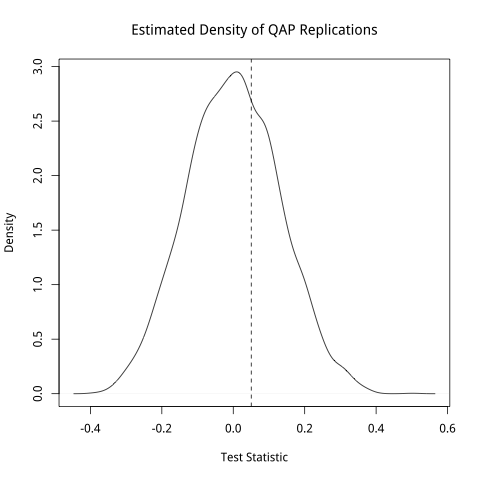

In [7]:
%%R
topo_adj <- array(as.matrix(read.csv('ground/space-syntax/topo-adj.csv',header=FALSE)), c(21,21))
topo_adj <- topo_adj[c(1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,20,21),c(1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,20,21)]
angular_adj <- array(as.matrix(read.csv('ground/space-syntax/angular-adj.csv',header=FALSE)), c(21,21))
angular_adj <- angular_adj[c(1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,20,21),c(1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,20,21)]
gcor(angular_adj, ground_adj)
write.csv(angular_adj,'ground/space-syntax/angular-adj-trimmed.csv')
write.csv(topo_adj,'ground/space-syntax/topo-adj-trimmed.csv')
graph.Cor = qaptest(list(-angular_adj, ground_adj), gcor, g1=1, g2=2, reps=5000)
plot(graph.Cor)

In [13]:
%%R
graphs = list(topo_adj, angular_adj, interaction_adj, ground_adj)
graphs[is.na(graphs)] <- 0
gcors <- gcor(graphs)
rownames(gcors) <- c('topological','angular','interaction\n model','overall\n ground')
colnames(gcors) <- c('topological','angular','interaction\n model','overall\n ground')
library(corrplot)
pdf(width=3.5, height=3.2, file='space-cor.pdf')
#corrplot.mixed(gcors, lower='number', lower.col='black', upper='shade', tl.col='black', tl.cex=0.6, cl.cex=0.5, number.cex=0.6, family='MyriadPro')

gcors_upper = gcors
UT = upper.tri(gcors_upper)
gcors_upper[UT] = gcors[UT]
diag(gcors_upper) = NA
corrplot(gcors_upper, type='upper', method='shade', tl.col='black', tl.pos='d', tl.srt=90, family='sans', addCoef.col = 'black', tl.cex=0.6, cl.cex=0.4, number.cex=0.6, family='Arial')